# 1. PyTorch
## 1-1. Containers
Your model should subclass `torch.nn.Module`. `torch.nn` holds basic build blocks for graphs.
1. `torch.nn.Module.parameters(recurse=True)`: Returns an iterator over module learnable parameters (weights & biases). This is typically passed to an optimizer.
2. `torch.nn.Module.named_parameters(prefix='', recurse=True, remove_duplicate=True)`: Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
3. `torch.nn.Module.to(device=None, dtype=None, non_blocking=False)`: Moves and/or casts the parameters and buffers.
4. `torch.nn.Module.load_state_dict(state_dict, strict=True, assign=False)`: Copies parameters and buffers from `state_dict` into this module and its descendants.
5. `torch.nn.Module.state_dict`: A Python dictionary object contains parameters & persistent buffers.

## 1-2. Loss Functions
1. Each PyTorch Loss function creates a criterion that measures the loss between `output` from a model and `target`, returning a `torch.Tensor`.
   - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
   - Metrics supporting backpropagation (`is_differentiable == True`) in **TorchMetrics** can be used. More details in [Metrics & Differentiability](https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metrics-and-differentiability).
3. `torch.Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)`: Computes the gradient of current tensor with reference to graph leaves. The graph is differentiated using the chain rule. This function accumulates gradients in the leaves.

## 1-3. Optimizer
`torch.optim` implements various [optimization algorithms](https://pytorch.org/docs/stable/optim.html#algorithms).
1. `torch.optim.Optimizer.step(closure=None)`: Performs a single optimization step (parameter update).
    - For example, [torch.optim.SGD.step(closure=None)](https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63).
2. `torch.optim.Optimizer.zero_grad(set_to_none=True)`: Resets the gradients of all optimized `torch.Tensor`s.
4. `torch.optim.Optimizer.load_state_dict(state_dict)`: Loads the optimizer state. Uses this function when loading a general checkpoint for inference or resuming training.
5. `torch.optim.Optimizer.state_dict`: Contains information about the optimizer's state (parameters to be optimized), as well as the hyperparameters used.
6. `torch.optim.Optimizer.add_param_group(param_group)`: Adds a param group to the `Optimizer`'s `param_groups`. Uses this function when fine tuning a pre-trained network as frozen layers can be made trainable and added to the `Optimizer` as training progresses.

In [10]:
import torch, torch.nn as nn

loss = nn.MSELoss()
# Model output
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5)
print(target)
output = loss(input, target)
print(output)
output.backward()
print(input.grad)

tensor([[-0.6368,  0.6902, -1.1642,  1.7340,  0.3089],
        [-0.5741, -2.2496,  0.1549,  0.2255, -0.5959],
        [ 0.6467,  0.2575,  1.8013,  0.4424, -0.4409]], requires_grad=True)
tensor([[-0.7584,  0.2138, -0.3933,  0.1054,  0.2149],
        [ 0.2793,  0.7960, -0.1902,  2.1231, -0.5180],
        [ 1.6648, -0.5898,  2.1185,  0.5762,  1.2281]])
tensor(1.4591, grad_fn=<MseLossBackward0>)
tensor([[ 0.0162,  0.0635, -0.1028,  0.2171,  0.0125],
        [-0.1138, -0.4061,  0.0460, -0.2530, -0.0104],
        [-0.1358,  0.1130, -0.0423, -0.0178, -0.2225]])


### 1-3-1. Gradient Accumulation
**Gradient accumulation** refers to the situation, where multiple backwards passes are performed before updating the parameters. The goal is to have the same model parameters for multiple inputs (batches) and then update the model's parameters based on all these batches, instead of performing an update after every single batch. This technique is used to overcome GPU memory limitations when training neural networks.
1. Manual Implementation
2. `pytorch_lightning.Trainer(accumulate_grad_batches)`
3. `accelerate.Accelerator(gradient_accumulation_steps)`

# 2. Linear Regression

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

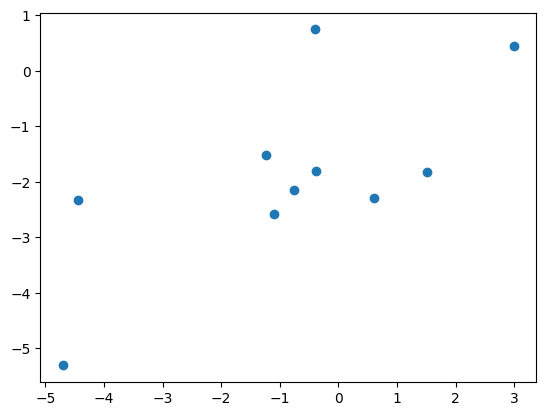

In [9]:
N = 10
# (-5, 5)
X = np.random.random(N) * 10 - 5
y = 0.5 * X - 1 + np.random.randn(N)

plt.scatter(X, y)

In [23]:
model = nn.Linear(1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

X = X.reshape(N, 1)
y = y.reshape(N, 1)

# NumPy creates `float64` by default
inputs = torch.from_numpy(X.astype(np.float32))
targets = torch.from_numpy(y.astype(np.float32))

type(inputs)

torch.Tensor

In [29]:
print(inputs)

tensor([[-0.7517],
        [-1.1045],
        [-1.2412],
        [-0.3923],
        [ 2.9923],
        [ 0.6128],
        [ 1.5206],
        [-4.7027],
        [-0.3810],
        [-4.4450]])


In [30]:
print(targets)

tensor([[-2.1424],
        [-2.5755],
        [-1.5125],
        [ 0.7460],
        [ 0.4411],
        [-2.2813],
        [-1.8139],
        [-5.3069],
        [-1.8115],
        [-2.3218]])


In [24]:
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [25]:
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 torch.Size([1, 1])
bias 	 torch.Size([1])


In [26]:
optimizer.zero_grad()

print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [27]:
outputs = model(inputs)

print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])
    # print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 tensor([[0.7652]])
bias 	 tensor([-0.3949])


In [28]:
# input * weight + bias
print(outputs)

tensor([[-0.9701],
        [-1.2401],
        [-1.3446],
        [-0.6951],
        [ 1.8947],
        [ 0.0740],
        [ 0.7686],
        [-3.9934],
        [-0.6865],
        [-3.7962]], grad_fn=<AddmmBackward0>)


In [31]:
# sum((output - target)^2) / 10 = 2.4758
loss = criterion(outputs, targets)
print(loss)

tensor(2.4758, grad_fn=<MseLossBackward0>)


In [32]:
loss.backward()

In [41]:
print(model.weight.grad)
print(model.bias.grad)

tensor([[1.5338]])
tensor([1.7180])


In [42]:
optimizer.step()

In [43]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [44]:
# 0.7652 - 1.5338 * 0.05 = 0.7652 - 0.07669 = 0.6885
# -0.3949 - 1.7180 * 0.05 = -0.4808
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [45]:
optimizer.zero_grad()

In [46]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [47]:
# Nothing changes
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [48]:
print(model.weight.grad)
print(model.bias.grad)

None
None


In [4]:
n_epochs = 30
losses = []
for it in range(n_epochs):
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f"Epoch {it+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 1/30, Loss: 3.7359
Epoch 2/30, Loss: 3.2713
Epoch 3/30, Loss: 2.9047
Epoch 4/30, Loss: 2.5957
Epoch 5/30, Loss: 2.3300
Epoch 6/30, Loss: 2.1002
Epoch 7/30, Loss: 1.9012
Epoch 8/30, Loss: 1.7288
Epoch 9/30, Loss: 1.5794
Epoch 10/30, Loss: 1.4499
Epoch 11/30, Loss: 1.3377
Epoch 12/30, Loss: 1.2405
Epoch 13/30, Loss: 1.1563
Epoch 14/30, Loss: 1.0833
Epoch 15/30, Loss: 1.0200
Epoch 16/30, Loss: 0.9652
Epoch 17/30, Loss: 0.9177
Epoch 18/30, Loss: 0.8765
Epoch 19/30, Loss: 0.8408
Epoch 20/30, Loss: 0.8099
Epoch 21/30, Loss: 0.7831
Epoch 22/30, Loss: 0.7599
Epoch 23/30, Loss: 0.7398
Epoch 24/30, Loss: 0.7223
Epoch 25/30, Loss: 0.7072
Epoch 26/30, Loss: 0.6941
Epoch 27/30, Loss: 0.6828
Epoch 28/30, Loss: 0.6730
Epoch 29/30, Loss: 0.6644
Epoch 30/30, Loss: 0.6571


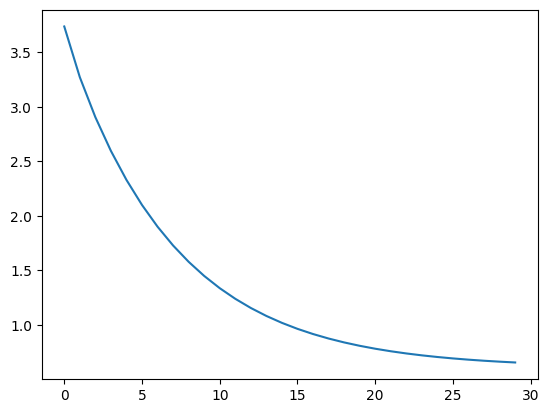

In [5]:
plt.plot(losses)

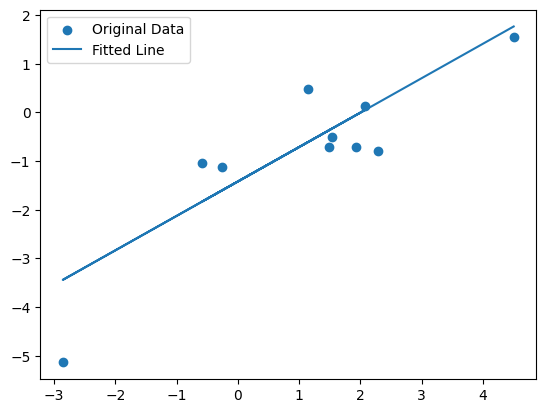

In [6]:
predictions = model(inputs).detach().numpy()
plt.scatter(X, y, label="Original Data")
plt.plot(X, predictions, label="Fitted Line")
plt.legend()
plt.show()

In [7]:
w = model.weight.data.numpy()
b = model.bias.data.numpy()
# (0.5, -1)
print(w, b)

[[0.70741653]] [-1.4193791]


# 3. Logistic Regression
**Binary Cross Entropy** for binary classification:
1. `torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')`
2. `torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)`: Combines a `Sigmoid` layer and the `BCELoss` in one single class.

In [177]:
from sklearn.datasets import load_breast_cancer

In [178]:
data = load_breast_cancer()
type(data)

sklearn.utils._bunch.Bunch

In [179]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [180]:
data.data.shape

(569, 30)

In [181]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [182]:
data.target.shape

(569,)

In [183]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [184]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
N, D = X_train.shape
N, D

(381, 30)

In [186]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
model = nn.Sequential(
    nn.Linear(D,1), 
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [187]:
y_train.shape

(381,)

In [188]:
y_train.astype(np.float32).reshape(-1, 1).shape

(381, 1)

In [189]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

In [137]:
n_epochs = 1000

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")

Epoch 50/1000, Train Loss: 0.5543, Test Loss: 0.5545
Epoch 100/1000, Train Loss: 0.4093, Test Loss: 0.4079
Epoch 150/1000, Train Loss: 0.3302, Test Loss: 0.3276
Epoch 200/1000, Train Loss: 0.2800, Test Loss: 0.2766
Epoch 250/1000, Train Loss: 0.2450, Test Loss: 0.2411
Epoch 300/1000, Train Loss: 0.2191, Test Loss: 0.2149
Epoch 350/1000, Train Loss: 0.1993, Test Loss: 0.1947
Epoch 400/1000, Train Loss: 0.1836, Test Loss: 0.1788
Epoch 450/1000, Train Loss: 0.1709, Test Loss: 0.1658
Epoch 500/1000, Train Loss: 0.1604, Test Loss: 0.1552
Epoch 550/1000, Train Loss: 0.1516, Test Loss: 0.1462
Epoch 600/1000, Train Loss: 0.1441, Test Loss: 0.1386
Epoch 650/1000, Train Loss: 0.1376, Test Loss: 0.1321
Epoch 700/1000, Train Loss: 0.1319, Test Loss: 0.1264
Epoch 750/1000, Train Loss: 0.1269, Test Loss: 0.1215
Epoch 800/1000, Train Loss: 0.1224, Test Loss: 0.1170
Epoch 850/1000, Train Loss: 0.1185, Test Loss: 0.1131
Epoch 900/1000, Train Loss: 0.1149, Test Loss: 0.1096
Epoch 950/1000, Train Loss: 0

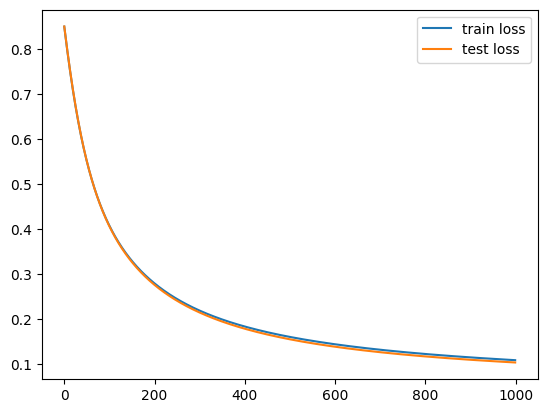

In [138]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [139]:
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    train_acc = np.mean(y_train.numpy() == p_train)

    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_acc = np.mean(y_test.numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9738, Test acc: 0.9734


In [190]:
# `BCEWithLogitsLoss()`
model_2 = nn.Linear(D,1)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_2.parameters())

In [191]:
n_epochs = 1000

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
train_acc = np.zeros(n_epochs)
test_acc = np.zeros(n_epochs)

for it in range(n_epochs):
    optimizer.zero_grad()

    outputs = model_2(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    outputs_test = model_2(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")

Epoch 50/1000, Train Loss: 0.5003, Test Loss: 0.4939
Epoch 100/1000, Train Loss: 0.3675, Test Loss: 0.3612
Epoch 150/1000, Train Loss: 0.2979, Test Loss: 0.2907
Epoch 200/1000, Train Loss: 0.2547, Test Loss: 0.2462
Epoch 250/1000, Train Loss: 0.2250, Test Loss: 0.2151
Epoch 300/1000, Train Loss: 0.2032, Test Loss: 0.1920
Epoch 350/1000, Train Loss: 0.1865, Test Loss: 0.1741
Epoch 400/1000, Train Loss: 0.1732, Test Loss: 0.1597
Epoch 450/1000, Train Loss: 0.1625, Test Loss: 0.1480
Epoch 500/1000, Train Loss: 0.1536, Test Loss: 0.1383
Epoch 550/1000, Train Loss: 0.1461, Test Loss: 0.1301
Epoch 600/1000, Train Loss: 0.1397, Test Loss: 0.1231
Epoch 650/1000, Train Loss: 0.1342, Test Loss: 0.1171
Epoch 700/1000, Train Loss: 0.1293, Test Loss: 0.1118
Epoch 750/1000, Train Loss: 0.1250, Test Loss: 0.1072
Epoch 800/1000, Train Loss: 0.1212, Test Loss: 0.1031
Epoch 850/1000, Train Loss: 0.1177, Test Loss: 0.0995
Epoch 900/1000, Train Loss: 0.1146, Test Loss: 0.0962
Epoch 950/1000, Train Loss: 0

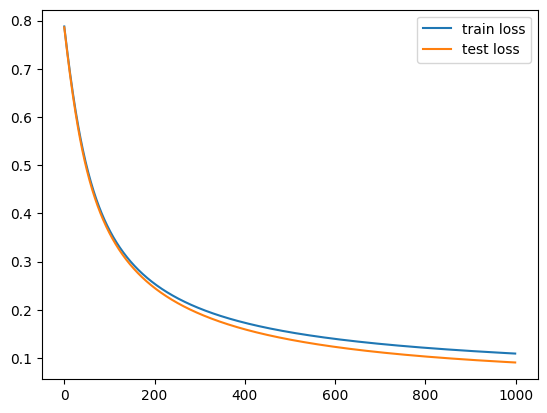

In [192]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [194]:
with torch.no_grad():
    p_train = model_2(X_train)
    p_train = (p_train.numpy() > 0)
    train_acc = np.mean(y_train.numpy() == p_train)

    p_test = model_2(X_test)
    p_test = p_test.numpy() > 0
    test_acc = np.mean(y_test.numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9738, Test acc: 0.9840


# 4. Deep Neural Networks (DNNs)
# 5. Convolutional Neural Networks (CNNs)
# 6. Recurrent Neural Networks (RNNs)
## 6-1. RNN
## 6-2. GRU
## 6-3. LSTM